<h1>
    <center>
        Detecta e classifica faces em uma imagem

# Bibliotecas necessárias

In [1]:
import cv2
import numpy as np
import dlib
import matplotlib.pyplot as plt
from scipy.spatial import distance as dist
from io import BytesIO
from IPython.display import clear_output, Image, display
from PIL import Image as Img
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models, losses, Model
from keras import datasets
from keras.models import model_from_json
from keras.models import Model
from keras.layers.merge import concatenate

# Carregar imagem

In [2]:
def carregar_imagem(caminho):
    imagem = cv2.imread(caminho)
    imagem = cv2.cvtColor(imagem, cv2.COLOR_BGR2RGB)
    return imagem

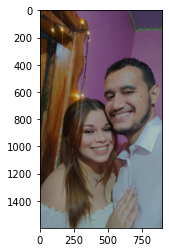

In [3]:
caminho = "imagens/nei_leticia.jpg"
imagem = carregar_imagem(caminho)
plt.imshow(imagem)

# Detecta faces

In [4]:
detector_face = dlib.get_frontal_face_detector()

In [5]:
def retangulo_delimitador(imagem):
    retangulos = detector_face(imagem, 0)
    delimitadores = [];
    if retangulos is not None:
        for k,d in enumerate(retangulos):
            cv2.rectangle(imagem, (d.left(),d.top()),(d.right(),d.bottom()),(255,255,0),2)
            if d.left() < 0:
                left = 0
            else:
                left = d.left()
            if d.right() < 0:
                right = 0;
            else:
                right = d.right()
            if d.top()< 0:
                top = 0
            else:
                top = d.top()
            if d.bottom()<0:
                bottom = 0
            else:
                bottom = d.bottom()
            delimitadores.append([top,bottom,left,right])
    return imagem,delimitadores

In [6]:
imagem_copia, delimitadores = retangulo_delimitador(imagem.copy())

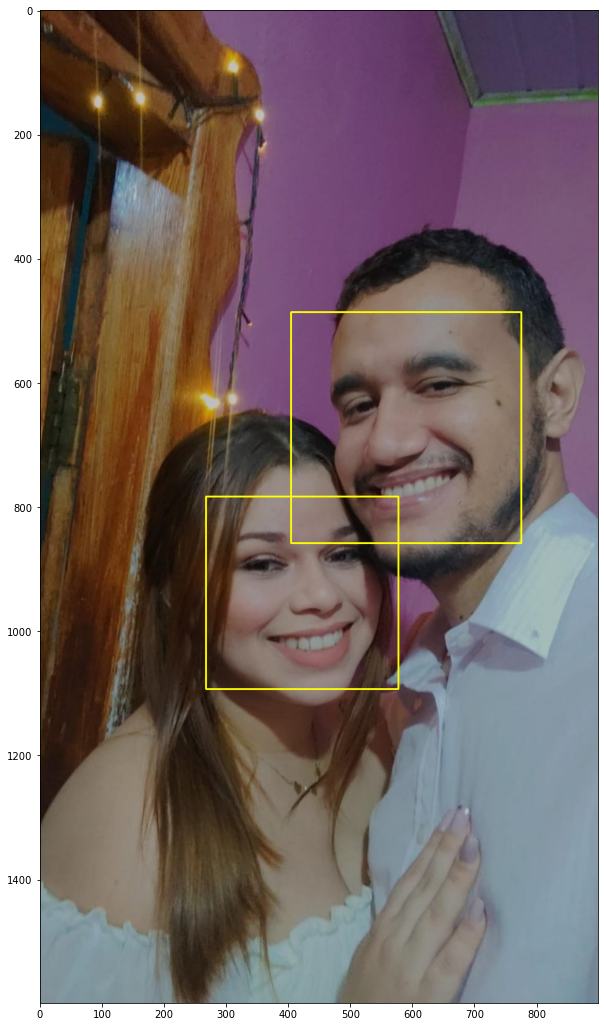

In [7]:
plt.figure(figsize=(10,20))
plt.imshow(imagem_copia)

### Teste do delimitador de faces

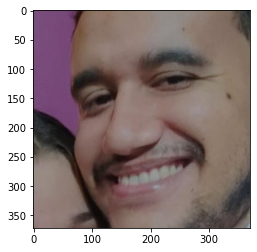

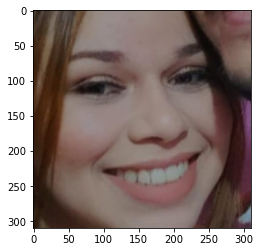

In [8]:
for i in range(len(delimitadores)):
    plt.imshow(imagem[delimitadores[i][0]:delimitadores[i][1],delimitadores[i][2]:delimitadores[i][3]])
    plt.show()

# Desenvolvimento do classificador

In [9]:
# load json and create model
json_file = open('model2.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model2.h5")
print("Loaded model from disk")

Loaded model from disk


In [10]:
def recortar_imagem(imagem,delimitadores):
    rostos = []
    dados = imagem.copy()
    if delimitadores!= []:
        for delimitador in delimitadores:
            imagem = cv2.resize(dados[delimitador[0]:delimitador[1],delimitador[2]:delimitador[3]],(224,224))
            rostos.append(np.asarray([imagem])/255)   
    return rostos

In [11]:
rostos = recortar_imagem(imagem,delimitadores)

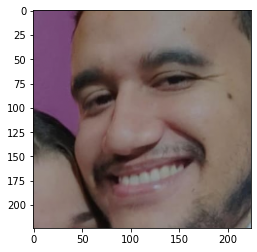

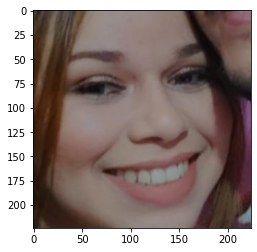

In [12]:
for rosto in rostos:
    plt.imshow(rosto[0])
    plt.show()

In [13]:
print(np.asarray(rostos).shape)
predicao = loaded_model.predict(rostos[0])

(2, 1, 224, 224, 3)


In [14]:
pessoas = ["Leticia", "Nei"]
max_value = max(predicao[0])
sujeito_identificado = np.argmax(predicao[0]==max_value)

In [15]:
print("Sujeito identificado: "+ pessoas[sujeito_identificado])
print("Certeza", max_value)

Sujeito identificado: Nei
Certeza 0.87921333


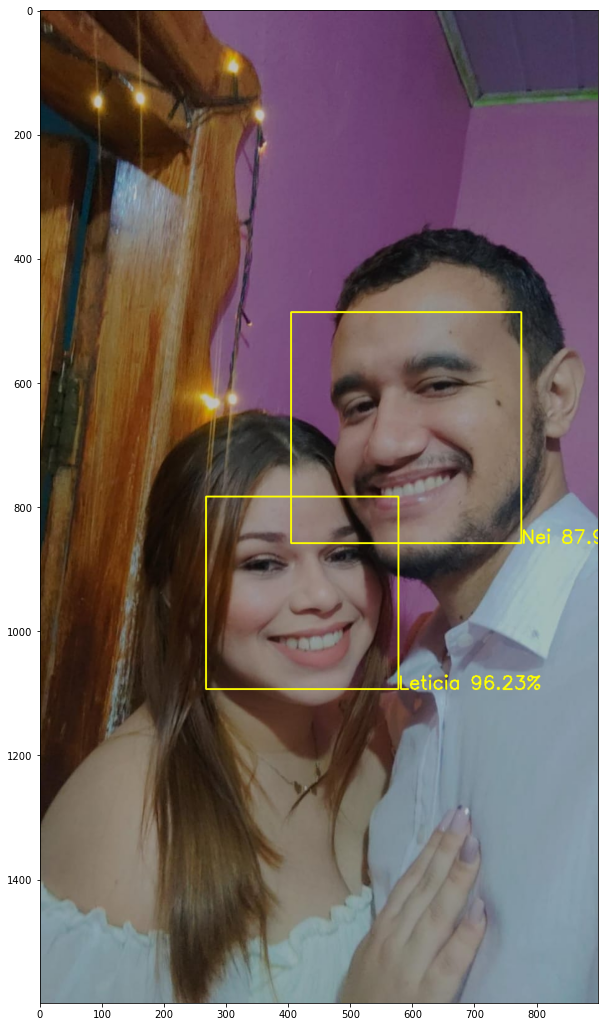

In [16]:
imagem_label = imagem_copia.copy()
for k,rosto in enumerate(rostos):
    predicao = loaded_model.predict(rosto)
    max_value = max(predicao[0])
    sujeito_identificado = np.argmax(predicao[0]==max_value)
    saida = pessoas[sujeito_identificado]+" "+str(round(max_value*100,2))+"%"
    cv2.putText(imagem_label, saida,(delimitadores[k][3],delimitadores[k][1]), cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,0),2)
plt.figure(figsize=(10,20))
plt.imshow(imagem_label)

#  Teste final do classificador

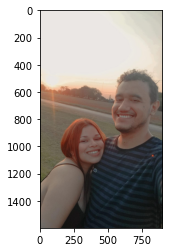

In [17]:
caminho = "imagens/t6.jpeg"
imagem = carregar_imagem(caminho)
plt.imshow(imagem)

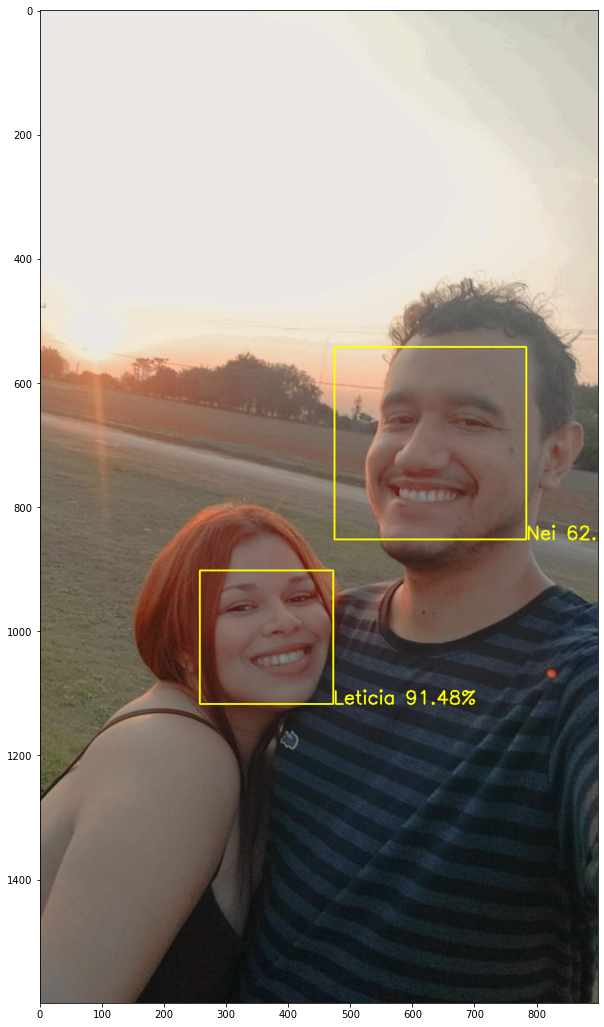

In [18]:
imagem_copia, delimitadores = retangulo_delimitador(imagem.copy())
rostos = recortar_imagem(imagem,delimitadores)
imagem_label = imagem_copia.copy()
for k,rosto in enumerate(rostos):
    predicao = loaded_model.predict(rosto)
    max_value = max(predicao[0])
    sujeito_identificado = np.argmax(predicao[0]==max_value)
    saida = pessoas[sujeito_identificado]+" "+str(round(max_value*100,2))+"%"
    cv2.putText(imagem_label, saida,(delimitadores[k][3],delimitadores[k][1]), cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,0),2)
plt.figure(figsize=(10,20))
plt.imshow(imagem_label)

# Webcam

In [19]:
def exibir_video(frame):
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    img = Img.fromarray(frame, "RGB")
    buffer = BytesIO()
    img.save(buffer, format = "JPEG")
    display(Image(data = buffer.getvalue()))
    clear_output(wait = True)

In [20]:
video = cv2.VideoCapture(0)

In [21]:
frame_count = 10
j = frame_count+1
try:
    while(True):
        captura_ok, frame = video.read()
        pessoa = ["Leticia","Nei"]
        if captura_ok:
            imagem_copia, delimitadores = retangulo_delimitador(frame.copy())
            rostos = recortar_imagem(frame,delimitadores)
            imagem_label = imagem_copia.copy()
            j += 1
            if j > frame_count:
                individuos = [];
                certeza = [];
                for k,rosto in enumerate(rostos):
                    predicao = loaded_model.predict(rosto)
                    max_value = max(predicao[0])
                    sujeito_identificado = np.argmax(predicao[0]==max_value)
                    individuos.append(sujeito_identificado)
                    certeza.append(max_value)
                    if k+1 == len(rostos):
                        j = 1
            if len(individuos) > 1:
                for k,individuo in enumerate(individuos):
                    if k < len(delimitadores):
                        saida = pessoas[individuo]+" "+str(round(certeza[k]*100,2))+"%"+"if"
                        cv2.putText(imagem_label, saida,(delimitadores[k][2],delimitadores[k][1]), cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,0),2)
            else:
                if delimitadores != []:
                    saida = pessoas[individuos[0]]+" "+str(round(certeza[k]*100,2))+"%"+"else"
                    cv2.putText(imagem_label, saida,(delimitadores[0][2],delimitadores[0][1]), cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,0),2)
            exibir_video(imagem_label)
        else:
            break

except KeyboardInterrupt:
    video.release()
    print("Interrompido")

Interrompido


In [30]:
j =1
frame_count = 0
try:
    while(True):
        captura_ok, frame = video.read()
        pessoa = ["Leticia","Nei"]
        if captura_ok:
            imagem_copia, delimitadores = retangulo_delimitador(frame.copy())
            rostos = recortar_imagem(frame,delimitadores)
            imagem_label = imagem_copia.copy()
            j += 1
            for k,rosto in enumerate(rostos):
                if j > frame_count:
                    if k == len(rostos):
                        j = 1
                    predicao = loaded_model.predict(rosto)
                    max_value = max(predicao[0])
                sujeito_identificado = np.argmax(predicao[0]==max_value)
                saida = pessoas[sujeito_identificado]+" "+str(round(max_value*100,2))+"%"
                cv2.putText(imagem_label, saida,(delimitadores[k][2],delimitadores[k][1]), cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,0),2)
            exibir_video(imagem_label)

except KeyboardInterrupt:
    video.release()
    print("Interrompido")

Interrompido


In [ ]:
len(delimitadores)